In [18]:
pip install  dask

     |████████████████████████████████| 960 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 32.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipwhois

     |████████████████████████████████| 73 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 208 kB 40.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

     |████████████████████████████████| 13.2 MB 11.7 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=f51a0a5b25073c7434c1328bf38219182c865c50e0682d10db139e029391b843
  Stored in directory: /root/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pyarrow

     |████████████████████████████████| 21.9 MB 12.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import itertools
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from multiprocessing import Manager

import datetime as dt
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import utils.helpers as hp
from utils.helpers import timer 
import model.queries as qrs

import os.path
from os import path

import logging
import os

logging.basicConfig(format = '%(asctime)s %(message)s',
                    datefmt = '%m/%d/%Y %I:%M:%S %p',
                    filename = 'progress.log',
                    level=logging.INFO)


import pyarrow as pa
import pyarrow.parquet as pq

def write2Parquet(df, filename):
    table = pa.Table.from_pandas(df, preserve_index=True)
    pq.write_table(table, filename)

    
    
dir_path = '/data/petya/parquet/trace_and_loss'
def saveData(df, file_name):
    with open(f"{dir_path}/{file_name}.pkl","wb") as f:
        pickle.dump(df,f)
        
def loadData(df):
    with open(f'{dir_path}/{df}.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)

Success


In [2]:
def scan_gen(scan):
    while True:
        try:
            yield next(scan)['_source']
        except:
            break

def ps_trace_hashes(dt,src, dest,include=["timestamp","route-sha1","hops","asns","destination_reached","src","dest","looping","path_complete"]):
    query = {
      "query" : {
        "bool" : {
          "must" : [
            {
              "range" : {
                "timestamp" : {
                  "gt" : dt[0],
                  "lte": dt[1]
                }
              }
            },
            {
              "term" : {
                'src' : {
                  "value" : src
                }
              }
            },
            {
              "term" : {
                'dest' : {
                  "value" : dest
                }
              }
            }
          ]
        }
      }
    }
#     print(str(query).replace("\'", "\""))
    try:
        return scan_gen(scan(hp.es,index="ps_trace",query=query, _source=include, filter_path=['_scroll_id', '_shards', 'hits.hits._source']))
    except Exception as e:
        print(e)
        
        
def getMeanLoss(dt, src, dest):
    q = {
          "size" : 0,
          "query" : {  
            "bool" : {
              "must" : [
                {
                  "range" : {
                    "timestamp" : {
                      "from" : dt[0],
                      "to" : dt[1]
                    }
                  }
                },
                {
                  "term" : {
                    "src" : src
                  }
                },
                {
                  "term" : {
                    "dest" : dest
                  }
                }
              ]
            }
          },
          "aggs": {
            "packet_loss": {
              "avg": {
                "field": "packet_loss"
              }
            }
          }
        }
#     print(str(q).replace("\'", "\""))
    
    data = hp.es.search(index='ps_packetloss', body=q, 
                _source=[ "packet_loss"])

    return data['aggregations']['packet_loss']['value']

    
def ps_packetloss(dt, src, dest, include=["timestamp","src","dest","packet_loss"]):
    query = {
      "query" : {
        "bool" : {
          "must" : [
            {
              "range" : {
                "timestamp" : {
                  "gt" : dt[0],
                  "lte": dt[1]
                }
              }
            },
            {
              "term" : {
                'src' : {
                  "value" : src
                }
              }
            },
            {
              "term" : {
                'dest' : {
                  "value" : dest
                }
              }
            }
          ]
        }
      }
    }
#     print(str(query).replace("\'", "\""))
    data = []
    try:
        gen = scan_gen(scan(hp.es,index="ps_packetloss",query=query, _source=include, filter_path=['_scroll_id', '_shards', 'hits.hits._source']))
        for meta in gen:
            data.append(meta)
            
        df = pd.DataFrame(data)
        if len(data)>0:
            df['dt'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
            
    except Exception as e:
        print(e)

        
def ps_trace(es, dt, src, dest):
    scan_gen = ps_trace_hashes(dt, src, dest)
    data = []
    hashes = {}
    records = 0

    for meta in scan_gen:
        data.append(meta)
#         print(meta)
        if 'route-sha1' in data[records]:
#         for doc in meta:
            hashes[meta['route-sha1']] = meta['hops']
        records += 1
        if not records % 500000:
            print(records)

    df = pd.DataFrame(data)
    if len(data)>0:
        df['dt'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df


In [3]:
import shutil



try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

try:
    os.makedirs(dir_path)
    os.makedirs(f'{dir_path}')
except OSError as e:
    pass

startDate, endDate = hp.defaultTimeRange(days = 1)
with open('/data/petya/period.pkl','wb') as outfile:
    pickle.dump([startDate, endDate],outfile)

dt = hp.GetTimeRanges(startDate, endDate)

### Get all tested pairs

In [4]:
%time pairs = qrs.queryAllTestedPairs(dt)
pairsDf = pd.DataFrame(pairs)

write2Parquet(pairsDf, '/data/petya/pairsDf')

CPU times: user 114 ms, sys: 22.8 ms, total: 136 ms
Wall time: 4.14 s


### Get ps_trace data pair by pair and store all pairs in a list

#### TODO: start a few threads for that to load

In [5]:
location = dir_path
tracedata = []
def getTraceData():
#     tracedata = []
    i = 0
    for src, dest in pairsDf[pairsDf['idx']=='ps_packetloss'][['src', 'dest']].values:
        data = ps_trace(hp.es, dt, src, dest)
        filename = f'{location}/{src}-{dest}.parquet'
        if len(data)>0:
#             tracedata.append({'src': src, 'dest': dest, 'data':data})
            tracedata.append(data)
            write2Parquet(data, filename)
        i+=1
    return tracedata

%time tracedata = getTraceData()


print('Number of src-dest pairs in ps_trace',len(tracedata))

CPU times: user 18.5 s, sys: 2.05 s, total: 20.6 s
Wall time: 4min 24s
Number of src-dest pairs in ps_trace 2993


### Calculate the packet loss between each two traceroute measures

##### Version Parquet

In [6]:
def splitUnknownPath(df):
    # print(df.loc[len(df)])
    try: 
        split_rows = []
        for idx, row in df[df['path_changed']==1].iterrows():
            if row['timestamp_prev']>0:
    #             print(row, )
                begin = row['timestamp']
                end = row['timestamp_prev']
                midpoint = int(begin + (end - begin) / 2)

                # Add a flag that will tell that the measurement was split in two by timestamp. All other values remain the same
                row['path_changed'] = 2
                # Mark the row which was divided in two separate measures with 3, in order to be deleted later
                df.loc[idx, 'path_changed'] = 3

                # first interval
                row['timestamp_prev'] = midpoint
                split_rows.append(row)
                # second interval
                row['timestamp'] = midpoint
                row['timestamp_prev'] = end

                split_rows.append(row)
        
        # add the new rows to the dataframe
        for i in range(0,len(split_rows)):
            df.loc[i+len(df)] = split_rows[i]

        # remove the original rows
        df = df[df['path_changed']<3]

        return df
    except Exception as e:
        print('2', split_rows[['src','dest']].values[0], e)


def calculatePathLoss(trace_df):
    
    try: 
        src = trace_df['src'][0]
        dest = trace_df['dest'][0]
        

        trace_df = trace_df.sort_values('timestamp', ascending=True)
        # get the previous row value
        trace_df['timestamp_prev'] = trace_df.timestamp.shift(1,fill_value=0)
        trace_df['route-sha1_prev'] = trace_df['route-sha1'].shift(1)
        plossDf = ps_packetloss([trace_df['timestamp'].min(), trace_df['timestamp'].max()],src, dest)

        def calcLoss(row):
            loss = None
            pathChanged = 1
            if row['timestamp_prev']>0:
                loss = plossDf[(plossDf['timestamp']<=row['timestamp']) & (plossDf['timestamp']>=row['timestamp_prev'])]['packet_loss'].mean()
                if row['route-sha1'] == row['route-sha1_prev']:
                    pathChanged = 0

            return pd.Series([loss, pathChanged])

        # in some cases there are no packetloss measures for the min-max time in traceroute measures
        if len(plossDf) > 0:
            trace_df[['loss', 'path_changed']] = trace_df.apply(calcLoss, axis=1)
            
            
            if len(trace_df[trace_df['path_changed']==1])>1:
                trace_df = splitUnknownPath(trace_df)

            filename = f"/data/petya/parquet/augmented/{trace_df['src'].unique()[0]}-{trace_df['dest'].unique()[0]}.parquet"

            # write to a pickle file
            if path.exists(filename):
                if os.path.getsize(filename) > 0:          
                    ff = pq.read_pandas(filename).to_pandas()

                    if len(ff) != len(trace_df) or any(x not in ff.columns for x in ['loss', 'path_changed']):
        #                     print('File not OK. Write!', len(ff), len(trace_df))
                        trace_df = write2Parquet(trace_df, filename)
                else: trace_df = write2Parquet(trace_df, filename)
            else:
                trace_df = write2Parquet(trace_df, filename)

            return trace_df
    
    except Exception as e:
        print('1', src, dest, e)

In [7]:
len(tracedata)

2993

### Run the calculations in parallel

In [8]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

pairsWithNoPathsRemoved = []
for i, df in enumerate(tracedata):
    if 'route-sha1' in df.columns:
        pairsWithNoPathsRemoved.append(df)
# print(f'There are {len(tracedata)-len(pairsWithNoPathsRemoved)} pairs missing route-sha1 field')

def addPacketLoss2Df():
    with ProcessPoolExecutor(max_workers=4) as pool:
        result = [res for res in pool.map(calculatePathLoss, pairsWithNoPathsRemoved) if res is not None]
    return result


%time tracedata = addPacketLoss2Df()

CPU times: user 1.83 s, sys: 897 ms, total: 2.73 s
Wall time: 4min 53s


## Merge all pairs into a Dask dataframe

In [9]:
import dask
import dask.dataframe as dd

files = []
for filename in os.listdir(dir_path):
    df = pd.read_parquet(f'{dir_path}/{filename}')
    # in some cases there are no packetloss measures for the min-max time in traceroute measures
    if 'loss' in df.columns:
        files.append(f'{dir_path}/{filename}')
    
    
mergedDf = dd.read_parquet(files, npartitions=4*4).compute()

In [10]:
len(mergedDf)

561997

### Build a dictionarry of hashes and their set of IP addresses

In [12]:
import os
import pickle
manager = Manager() 
hashDict = manager.dict()

def getHashes2IPlist(filename):
    df = pd.read_parquet(f'{dir_path}/{filename}')
    
    for path in df['route-sha1'].unique().tolist():
        hops = df[df['route-sha1']==path]['hops'].to_list()
        if len(hops)>0:
            hashDict[path] = hops[0].tolist()


def run():
    files = os.listdir(dir_path)
    with ProcessPoolExecutor(max_workers=4) as pool:
        pool.map(getHashes2IPlist, files)

    print(f'Number of unique paths: {len(hashDict)}')
    saveData(dict(hashDict), 'hashDict')
    return dict(hashDict)

%time hashDict = run()

Number of unique paths: 70108
CPU times: user 4.85 s, sys: 3.13 s, total: 7.99 s
Wall time: 27.7 s


In [13]:
saveData(dict(hashDict), 'hashDict')

### Get only the good paths, loop and extract the hops

In [42]:
# badPathsRemoved = mergedDf[(mergedDf['looping']==False)&(mergedDf['path_complete']==True)]
# aggmerged = badPathsRemoved.groupby(['route-sha1', 'src', 'dest']).agg({'loss': 'mean'}).reset_index()

# assign an id to each hop

paths = mergedDf.groupby(['route-sha1', 'src', 'dest']).agg({'loss': 'mean'}).reset_index()
logging.info(f'Number of paths {len(paths)}')
hopsList = []
hash2hopsIds = {}

def f(row):
    path = row['route-sha1']
    hops = hashDict[path]
    if len(hops)>0:
#         hops = None

        # add source to the list of hops to mark the first hop
        if row['src'] != hops[0]:
            hops.insert(0, row['src'])
        ids = []
        if 
        for i, ip in enumerate(hops):
            if i < len(hops)-1:
                # do not add looping values 
                if hops[i] != hops[i+1]:
                    hopsList.append({'src': row['src'], 'dest': row['dest'], 'hash': row['route-sha1'],
                                     'pos': i, 'hop': (hops[i], hops[i+1]), 'path_mean': row['loss'],
                                     'start': hops[i], 'end': hops[i+1]
                                    })
#                     ids.append(hopsId[(hops[i], hops[i+1])])
#         hash2hopsIds[path] = ids
    if row.name%5000 == 0:
        logging.info(f'Reached {row.name}')


# get information about the hops
paths.apply(f, axis=1)

hopsDf = pd.DataFrame.from_dict(hopsList, orient='columns')
# hopsDf[['start', 'end']] = pd.DataFrame(hopsDf['hop'].tolist(), index=hopsDf.index)
hopsId = {x: i for i, x in enumerate(hopsDf['hop'].unique())}
hopsDf['hop_id'] = hopsDf['hop'].apply(lambda h: hopsId[h])


saveData(hopsDf, 'hopsDf')

In [43]:
hopsDf.head()

,src,dest,hash,pos,hop,path_mean,start,end,hop_id
0,2001:610:108:203a::31,2001:48a8:68f7:8001:192:41:236:31,0001396e2f1a2cc8b8a1d29e56e5b5537115c64d,0,"(2001:610:108:203a::31, 2001:610:108:203a::2)",0.0,2001:610:108:203a::31,2001:610:108:203a::2,0
1,2001:610:108:203a::31,2001:48a8:68f7:8001:192:41:236:31,0001396e2f1a2cc8b8a1d29e56e5b5537115c64d,2,"(2001:610:108:203a::2, 2001:610:108:1025::1)",0.0,2001:610:108:203a::2,2001:610:108:1025::1,1
2,2001:610:108:203a::31,2001:48a8:68f7:8001:192:41:236:31,0001396e2f1a2cc8b8a1d29e56e5b5537115c64d,3,"(2001:610:108:1025::1, 2001:798:111:1::49)",0.0,2001:610:108:1025::1,2001:798:111:1::49,2
3,2001:610:108:203a::31,2001:48a8:68f7:8001:192:41:236:31,0001396e2f1a2cc8b8a1d29e56e5b5537115c64d,5,"(2001:798:111:1::49, 2001:400:f002:39::5)",0.0,2001:798:111:1::49,2001:400:f002:39::5,3
4,2001:610:108:203a::31,2001:48a8:68f7:8001:192:41:236:31,0001396e2f1a2cc8b8a1d29e56e5b5537115c64d,6,"(2001:400:f002:39::5, 2001:400:f002:39::6)",0.0,2001:400:f002:39::5,2001:400:f002:39::6,4


In [44]:
def f(row):
    path = row['route-sha1']
    hops = hashDict[path]
    if len(hops)>0:
#         hops = None
        # add source to the list of hops to mark the first hop
        if row['src'] != hops[0]:
            hops.insert(0, row['src'])
        ids = []
        for i, ip in enumerate(hops):
            if i < len(hops)-1:
                # do not add looping values 
                if hops[i] != hops[i+1]:
                    ids.append(hopsId[(hops[i], hops[i+1])])
        hash2hopsIds[path] = ids
    if row.name%5000 == 0:
        logging.info(f'Reached {row.name}')


# get information about the hops
paths.apply(f, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
70584    None
70585    None
70586    None
70587    None
70588    None
Length: 70589, dtype: object

In [45]:
list(hopsId)[2]

# hopsId[('2001:660:3031:110:ffff::221', '2001:660:3031:110:ffff::222')]
hopsDf
hopsDf[(hopsDf['start']=='2001:660:3031:110:ffff::221')&(hopsDf['end']=='2001:660:3031:110:ffff::222')]

,src,dest,hash,pos,hop,path_mean,start,end,hop_id
17863,2001:660:3031:110:ffff::221,2001:12d0:8120::135,048cdc9f0bbf95640b3a61684b39f3d358893e20,0,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000006,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
17880,2001:660:3031:110:ffff::222,2001:12d0:8120::136,048cdc9f0bbf95640b3a61684b39f3d358893e20,1,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000042,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
17927,2001:660:3031:110:ffff::221,2001:12d0:8120::135,04901888f8bd7ed2c8846804abaece32a09c7e1e,0,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000060,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
17943,2001:660:3031:110:ffff::222,2001:12d0:8120::136,04901888f8bd7ed2c8846804abaece32a09c7e1e,1,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000152,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
44750,2001:660:3031:110:ffff::221,2001:12d0:8120::135,0b7a74310ecfa89d3404e9792229ed20fb583022,0,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000142,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
...,...,...,...,...,...,...,...,...,...
936933,2001:660:3031:110:ffff::222,2001:12d0:8120::136,fa4ebc6bbac163a2e123a86ccf87cca928756ef2,1,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000000,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
947552,2001:660:3031:110:ffff::221,2001:12d0:8120::135,fd1fe58224f0ffbfabbd39f1b2b79bed464caa03,0,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000035,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
947567,2001:660:3031:110:ffff::222,2001:12d0:8120::136,fd1fe58224f0ffbfabbd39f1b2b79bed464caa03,1,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000000,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183
951114,2001:660:3031:110:ffff::221,2001:b30:800:f0f0:141:85:240:231,fe018303632bc71040d649b2d684bc5221d6b553,0,"(2001:660:3031:110:ffff::221, 2001:660:3031:11...",0.000017,2001:660:3031:110:ffff::221,2001:660:3031:110:ffff::222,3183


In [51]:
hash2hopsIds[list(hash2hopsIds)[2]]

hashDf = mergedDf.groupby('route-sha1')[['loss']].mean().reset_index()
hashDf['hops_ids'] = hashDf['route-sha1'].apply(lambda path: hash2hopsIds[path])
hashDf
saveData(hashDf, 'hashDf')

### Get mean, median, mode for each hop and assign an id 

In [47]:
import concurrent.futures
import math


def getStats(hop):
    hashList =  hopsDf[(hopsDf['hop']==hop)]['hash'].to_list()
    loss = mergedDf[mergedDf['route-sha1'].isin(hashList)]['loss']

    mean, median, mode = None, None, None
    if loss.isnull().values.all()==False:
        mean = loss.mean()
        median = loss.median()
        mode = loss.mode()[0]

    if hopsId[hop]%1000 == 0:
        logging.info(f'Passed:, {hopsId[hop]}')
        
    return {
        'hop_id': hopsId[hop],
        'hop': hop,
        'mean': mean,
        'median': median,
        'mode': mode
    }


def multi_processing():
    items = []
    uhops = hopsDf['hop'].unique()
    print('Number of hops: ',len(uhops))
    with  concurrent.futures.ProcessPoolExecutor(max_workers=4) as p:
        processing = p.map(getStats, uhops)
    print('Done')
    for data in processing:
        items.append(data)
        
    return items

%time hopStats = multi_processing()

hopStatsDf = pd.DataFrame(hopStats)
saveData(hopStatsDf, 'hopStatsDf')

Number of hops:  8311
Done
CPU times: user 6.18 s, sys: 1.5 s, total: 7.69 s
Wall time: 5min 21s


### Get the number of unique paths for each hop

In [48]:
numHashesDf = hopsDf.groupby(['hop']).agg({'hash': 'count'})
numHashesDf.rename(columns={'hash':'num_hashes'}, inplace=True)
relDf = pd.merge(hopStatsDf, numHashesDf, on='hop')
relDf.sort_values('mean', ascending=False)

saveData(relDf, 'relDf')

### Plot path mean loss to unique paths relationship

<AxesSubplot:xlabel='mean', ylabel='num_hashes'>

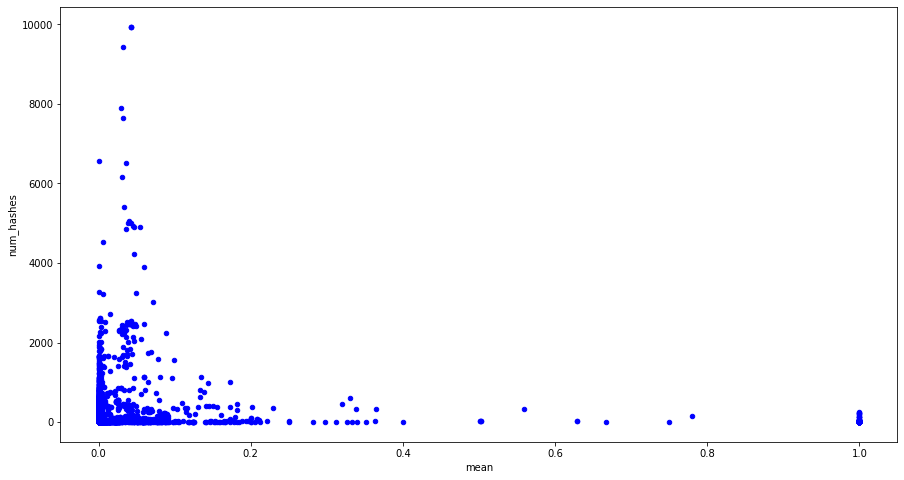

In [49]:
relDf.plot.scatter( x="mean", y="num_hashes", rot=0, color="b", figsize=(15,8))

### Check the distribution of number of unique hashes

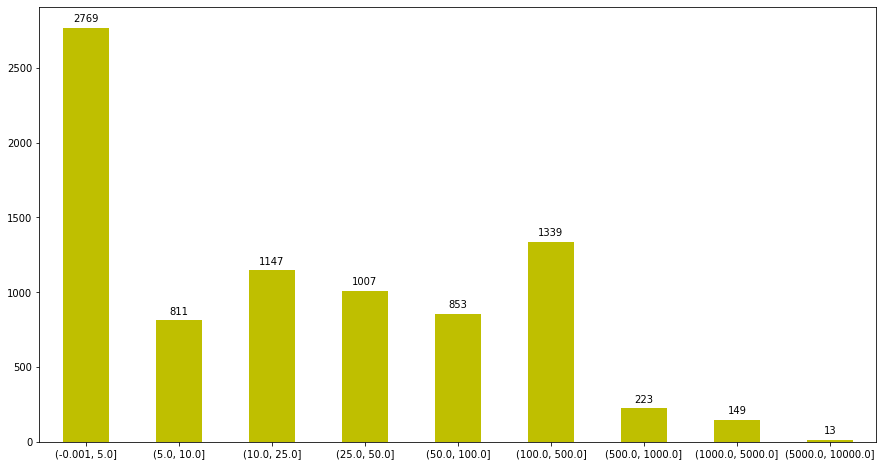

In [50]:
out = pd.cut(relDf['num_hashes'], bins=[0, 5, 10, 25, 50, 100, 500, 1000, 5000, 10000], include_lowest=True)
ax3 = out.value_counts(sort=False).plot.bar(rot=0, color="y", figsize=(15,8))
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')